# Movie Recommender System
### In this experiment, we will build movie recommender systems inspired by the following papers:

http://cs229.stanford.edu/proj2012/BaoXia-MovieRatingEstimationAndRecommendation_FinalWriteup.pdf
https://grouplens.org/site-content/uploads/Item-Based-WWW-2001.pdf

### using the data downloaded from the following site: https://grouplens.org/datasets/movielens/100k/. The dataset consists of 943 users and 1682 movies in which each user has rated at least 20 movies.
### In order to compare results between different training sets and testing sets, as well as for model comparison between different algorithms, we will just use ua.base / ua.test for simplicity.
### To start with, Let's read in the downloaded data using pandas.

In [1]:
import pandas as pd
print('pandas version is {}.'.format(pd.__version__))

# Read in each file. We use sep='\t' (tab separation) since the data in each file are separated by tabs.
# The files have no column names, so we use header=None, and will make up our column names by using the names parameter.
print("Reading in the data files...", end="")
df_uabase = pd.read_csv('ua.base', sep='\t', header=None, names=['UserID', 'ItemID', 'Rating', 'Timestamp'])
df_uatest = pd.read_csv('ua.test', sep='\t', header=None, names=['UserID', 'ItemID', 'Rating', 'Timestamp'])
df_ubbase = pd.read_csv('ub.base', sep='\t', header=None, names=['UserID', 'ItemID', 'Rating', 'Timestamp'])
df_ubtest = pd.read_csv('ub.test', sep='\t', header=None, names=['UserID', 'ItemID', 'Rating', 'Timestamp'])
df_u = pd.read_csv('u.data', sep='\t', header=None, names=['UserID', 'ItemID', 'Rating', 'Timestamp'])
print("Done!")

pandas version is 0.20.1.
Reading in the data files...Done!


### Let's see what one of these dataframes looks like. As for the column names we just created, UserID refers to the ID number of each reviewer, ItemID is the ID number of a movie being rated, Rating is the score that the user gave the movie (1-5), and Timestamp is the time at which the rating was recorded.

In [2]:
print(df_u)

       UserID  ItemID  Rating  Timestamp
0         196     242       3  881250949
1         186     302       3  891717742
2          22     377       1  878887116
3         244      51       2  880606923
4         166     346       1  886397596
5         298     474       4  884182806
6         115     265       2  881171488
7         253     465       5  891628467
8         305     451       3  886324817
9           6      86       3  883603013
10         62     257       2  879372434
11        286    1014       5  879781125
12        200     222       5  876042340
13        210      40       3  891035994
14        224      29       3  888104457
15        303     785       3  879485318
16        122     387       5  879270459
17        194     274       2  879539794
18        291    1042       4  874834944
19        234    1184       2  892079237
20        119     392       4  886176814
21        167     486       4  892738452
22        299     144       4  877881320
23        291   

### Let's also verify that the dataset indeed consists of 943 users and 1682 movies, respecitvely by printing out the max. value from the UserID and ItemID columns (e.g. the largest (last) UserID should be 943 since there are 943 total users).

In [3]:
print(max(df_u['UserID'])) # expected 943
print(max(df_u['ItemID'])) # expected 1682

943
1682


### OK, now that we have read in and verified the data, we will begin by plotting histograms as follows:
### a. Plot the histogram of the variable #movie_ratings = number of ratings for a movie.
### b. Plot the histogram of the variable #user_ratings = number of ratings for a user
### For convenience, we will use the file u.data (e.g. the dataframe df_u), which contains all 100,000 ratings (whereas the other files split the data into training / testing data). 
### Let's count up the no. of ratings given by each user, as well as the no. of ratings received by each movie.

In [4]:
from collections import Counter

# Initialize dictionary to keep track of number of ratings by each user, and number of rating for each movie.
num_ratings_by_users = Counter()
num_ratings_for_movies = Counter()

# Let's extract the numpy array from the dataframe by using .values
np_u = df_u.values
# print("Number of rows and cols in np_u (expected 100000, 4): {}".format(np_u.shape)) # Expected 100000 rows and 4 cols

print("Counting up the no. of ratings given out by each user, as well as the no. of rating each movie received...", end="")
# Now count the number of ratings given out by each user, as well as the number of ratings each movie received.
for row in np_u:
    userID = row[0]
    movieID = row[1]
    num_ratings_by_users[userID] += 1
    num_ratings_for_movies[movieID] += 1
print("Done!")

Counting up the no. of ratings given out by each user, as well as the no. of rating each movie received...Done!


### Let's re-verify that there are 943 total unique users and 1682 unique movies, as stated earlier.

In [5]:
total_users = len(num_ratings_by_users)
total_movies = len(num_ratings_for_movies)
print("Total no. of users (expected 943): {}".format(total_users)) # expected 943 users
print("Total no. of movies (expected 1682): {}".format(total_movies)) # expected 1682 movies

Total no. of users (expected 943): 943
Total no. of movies (expected 1682): 1682


### For plotting the histograms, we don't need the keys of the counter -- we only need the values.

In [6]:
user_ratings = list(num_ratings_by_users.values())
movie_ratings = list(num_ratings_for_movies.values())

### For sanity check, let's print the 10 smallest elements of the lists. Since each user gave at least 20 ratings and each movie received at least 1 rating, we should not see anything smaller than these, respectively.

In [7]:
# This shows the no. of ratings given by the 10 LEAST active users (users that gave the fewest ratings)
# Since each user gave at least 20 ratings, we should not see any value less than 20 here.
print (sorted(user_ratings)[:10])

# This shows the no. of ratings received by the 10 LEAST rated movies. Each movie received at least 1 rating.
print (sorted(movie_ratings)[:10])

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### We are now ready to plot the histograms. Naturally, we expect to find that the majority of users gave only a few ratings per person, and most movies received only a few ratings each.

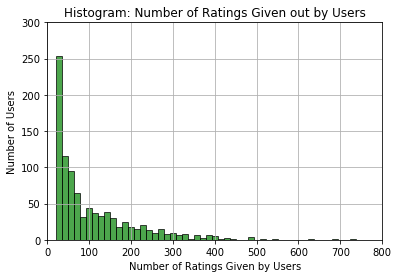

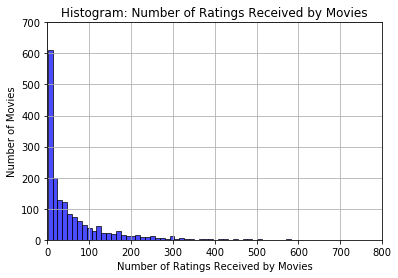

In [10]:
import matplotlib.pyplot as plt
# n, bins, patches = plt.hist(ratings_by_users_values, 50, normed = 1) # Update: commented out. No need to normalize

# User ratings histogram. We'll arbitrarily use 50 bins as it seems reasonable enough. alpha for transparency.
n, bins, patches = plt.hist(user_ratings, 50, facecolor = 'green', alpha = 0.70, edgecolor = "black")
plt.xlabel('Number of Ratings Given by Users')
plt.ylabel('Number of Users')
plt.title('Histogram: Number of Ratings Given out by Users')
plt.axis([0, 800, 0, 300])
plt.grid(True)
plt.show()

# Movie ratings histogram.
plt.hist(movie_ratings, 50, facecolor = 'blue', alpha = 0.70, edgecolor = "black")
plt.xlabel('Number of Ratings Received by Movies')
plt.ylabel('Number of Movies')
plt.title('Histogram: Number of Ratings Received by Movies')
plt.axis([0, 800, 0, 700])
plt.grid(True)
plt.show()

### Next, we will build a recommender system. For this, the training and testing data will be pre-processed as follows: we apply the database to build a U by I matrix A, where U is the number of users, and I is the number of rated movies. Each element A_ui denotes the rating scored by the u-th user for the i-th movie.
### We know from above that U = 943 users and I = 1682 movies, so the size of matrix A will be 943 x 1682.
### From this point on, we will no longer use the file u.data. Instead, let's create a matrix separately for each training / testing data file: ua.base / ua.test.

In [13]:
import numpy as np

# Get the numpy array versions of the dataframes corresponding to ua.base and ua.test
np_uabase = df_uabase.values
np_uatest = df_uatest.values

# Sanity check. Expected 100000 total ratings
print("Total no. of ratings (expected 100000): {}".format(len(np_uabase) + len(np_uatest)))

print("Initializing and populating matrices separately for ua.base and ua.test...", end="")
# Initialize empty 943 x 1682 matrix separately for ua.base and ua.test
A_uabase = np.zeros( (total_users, total_movies) )
A_uatest = A_uabase.copy()

# Method to fill up the matrix according to the data in a given file.
# @param A: a 2D array
# @param datafile: given training (or testing) file
def populateMatrix(A, datafile):
    for row in datafile:
        userID = row[0]
        movieID = row[1]
        rating = row[2]
        
        #UserID's range from 1-943 and movieID's from 1-1682, thus in order to prevent out of index range error,
        # we decrement each by 1 before updating the matrix A (which is of course indexed starting from 0).
        A[userID-1][movieID-1] = rating
# end populateMatrix

# Invoke the custom method to populate the two matrices.
populateMatrix(A_uabase, np_uabase)
populateMatrix(A_uatest, np_uatest)

print("Done.")
# Expected (943, 1682) for all
print("Dimension of A_uabase (expected 943, 1682): {}".format(A_uabase.shape))
print("Dimension of A_uatest (expected 943, 1682): {}".format(A_uatest.shape))

def checkValid(A):
    for row in A:
#         invalidElements = [element for element in row if element != 0 and element != 1 and element != 2 and element != 3 and element != 4 and element != 5]
        invalidElements = [element for element in row if element < 0 or element > 5]
        if (len(invalidElements) > 0):
            raise ValueError("ERROR!")

# sanity check. Every element in these matrices must have a movie rating ranging from 1 to 5 if the user rated the movie,
# or 0 otherwise
checkValid(A_uabase)
checkValid(A_uatest)

Total no. of ratings (expected 100000): 100000
Initializing and populating matrices separately for ua.base and ua.test...Done.
Dimension of A_uabase (expected 943, 1682): (943, 1682)
Dimension of A_uatest (expected 943, 1682): (943, 1682)


### Let's observe a single row of these matrices. Most of the entries should be zero (as the matrix is expected to be sparse).

In [14]:
print([element for element in A_uabase[942]],'\n')
print([element for element in A_uatest[798]],'\n')

[0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 4.0, 0.0, 0.0, 4.0, 4.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 4.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 1.0, 0.0, 3.0, 4.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 5.0, 0.0, 0.0, 4.0, 4.0, 5.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 4.0, 0.0, 0.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 4.0, 0.0, 4.0, 2.0, 5.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 3.0, 1.0, 0.0, 3.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 4.0, 5.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 5.0, 0.0, 5.0, 2.0, 0.0, 5.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 5.0, 4.0, 5.0, 0.0, 0.0, 0.0, 4.0,

### We are ready to build a recommender system based on the training data, with the following baseline predictor for a (u,i) pair:
### b_ui = μ + b_u + b_i, where:
### 1) μ = the global average rating across all movies and users
### 2) bu and bi = the deviations of user u and movie i, respectively, from the average.
### For instance, let (u, i) = (Charlie, "Shindler's List"). Further, assume that the global average rating is μ = 3.5 stars. Further assume "Shinder's List"s average rating across all users is 0.7 stars above the global average. Finally, assume that Charlie is rather harsh when it comes to rating movies, and his average rating across all movies is 0.3 stars lower than the global average. Then, the estimated (predicted) rating by Charlie of the movie "Shindler's List" would be: b_ui = μ + b_u + b_i = 3.5 + (-0.3) + 0.7 = 3.9 stars.
### We will compute μ, b_u and b_i in accordance with the formulas shown on p. 148-149 of the book "Recommender Systems Handbook" by Francesco Ricci, Lior Rokach, Bracha Shapira, and Paul B. Kantor (2011).
### First, we compute μ as follows:

In [15]:
# Computes μ, the global average rating across all movies and users for a given dataframe file
# @param df: a dataframe file e.g. df_uabase. It is assumed that df has a column named 'Rating'
def compute_mu(df):
    # take the mean of ALL the elements in the column titled 'Rating'. This is the global average rating.
    return np.mean(df['Rating'].values)

# Call the custom method to compute μ for the training files.
mu_uabase = compute_mu(df_uabase)

print("Avg. rating across all movies for ua.base: {}".format(mu_uabase))

Avg. rating across all movies for ua.base: 3.5238268742409184


### Second, we compute b_i:

In [16]:
'''
Compute b_i:

        sum_{u /in R[i]} (r_ui - mu) 
b_i =   ----------------------------
             lambda_2 + |R[i]|

where:
R[i] = set of users who rated movie item i
r_ui = the rating that user u gave to movie i
mu = the global average rating across all movies and users
lambda_2 = regularization parameter to avoid overfitting. We use a value of 25.
|R[i]| = no. of users who rated movie item i

'''
# @param A: a preprocessing matrix pertaining to a training file (e.g. ua.base), where
#           A[u][i] = the rating (1-5) that userindex u gave to movieindex i.
#           Note: if A[u][i] = 0, then the user didn't rate the movie.
# @param mu: the global average rating across all movies and users for the training file represented by A
# @param lambda_2: regularization parameter to avoid overfitting, etc. Set to 25 by default.
def compute_bi(A, mu, lambda_2 = 25):
    A_tr = A.transpose()
    total_num_movies = len(A_tr)
    b_i = np.zeros(total_num_movies)
    for i in range(total_num_movies):
        list_of_ratings_that_exist_for_movie_item_i = A_tr[i][A_tr[i, :] > 0]
        numerator = np.sum(list_of_ratings_that_exist_for_movie_item_i - mu)
        denominator = lambda_2 + len(list_of_ratings_that_exist_for_movie_item_i)
        b_i[i] = numerator / denominator
    return b_i

b_i_uabase = compute_bi(A_uabase, mu_uabase)

### Third, we compute b_u:

In [17]:
'''
Compute b_u:

       sum_{i /in R[u]} (r_ui - mu - b_i)
b_u =  ----------------------------------
             lambda_3 + |R[u]|

where:
R[u] = set of movies that were rated by user u
r_ui = the rating that user u gave to movie i
mu = the global average rating across all movies and users
b_i = defined above
lambda_3 = regularization parameter to avoid overfitting. We use a value of 10.
|R[u]| = no. of movies that were rated by user u
'''
# @param A: a preprocessing matrix pertaining to a training file (e.g. ua.base), where
#           A[u][i] = the rating (1-5) that userindex u gave to movieindex i.
#           Note: if A[u][i] = 0, then the user didn't rate the movie.
# @param mu: the global average rating across all movies and users for the training file represented by A
# @param b_i: a vector containing the deviations of each movie from the global average, mu.
# @param lambda_3: regularization parameter to avoid overfitting, etc. Set to 10 by default.
def compute_bu(A, mu, b_i, lambda_3 = 10):
    total_num_users = len(A)
    b_u = np.zeros(total_num_users)
    for u in range(total_num_users):
        movie_indices_rated_by_u = [i for i in range(len(A[u])) if A[u][i] > 0]
        numerator = np.sum((A[u][movie_indices_rated_by_u] - mu - b_i[movie_indices_rated_by_u]))
        denominator = lambda_3 + len(movie_indices_rated_by_u)
        b_u[u] = numerator / denominator
    return b_u

b_u_uabase = compute_bu(A_uabase, mu_uabase, b_i_uabase)

### Finally, we build the recommender system matrix R.

In [18]:
'''Build recommender system'''
def buildRecommenderSys(mu, b_u, b_i):
    total_num_users = len(b_u)
    total_num_movies = len(b_i)
    R = np.zeros((total_num_users, total_num_movies))
    for u in range(total_num_users):
        for i in range(total_num_movies):
            R[u][i] = mu + b_u[u] + b_i[i]
    return R

R_ua = buildRecommenderSys(mu_uabase, b_u_uabase, b_i_uabase)

### Now that we have a recommender system built, let us check the overall RMSE by comparing the predicted ratings with the actual ratings in the test set. The RMSE should be approximately equal to 0.96648.

In [19]:
def compute_overall_RMSE(R, np_test):
    summation = 0.0
    for row in np_test:
        userID = row[0] - 1
        movieID = row[1] - 1
        rating = row[2]
#         print(userID, movieID, rating, R[userID][movieID])
        if(R[userID][movieID] == 0):
            print("R[u][i] = 0!")
        summation += ((R[userID][movieID] - rating) ** 2)
#         print("(R[userID][movieID] - rating) ** 2 = {}".format((R[userID][movieID] - rating) ** 2))
#         print("summation is updated to: {}".format(summation))
        
#     print("summation:", summation)
    RMSE = (summation / len(np_test)) ** (1/2)
    return RMSE

RMSE_ua = compute_overall_RMSE(R_ua, np_uatest)
print(RMSE_ua)

0.966481783888


### Now let's compute the RMSE separately for each rating (1-5). For example, what is the RMSE for only those movies in the test data that received actual ratings of 1? In the same way, we will compute the RMSE for ratings 2-5 as well.

In [20]:
def compute_RMSE_partial(R, np_test, rating_to_consider = 1):
    summation = 0.0
    np_test_considered = 0
    for row in np_test:
        userID = row[0] - 1
        movieID = row[1] - 1
        rating = row[2]
        if (rating != rating_to_consider):
            continue
        np_test_considered += 1
        summation += ((R[userID][movieID] - rating) ** 2)
    RMSE = (summation / np_test_considered) ** (1/2)
    return RMSE

RMSE_r1 = compute_RMSE_partial(R_ua, np_uatest, 1)
RMSE_r2 = compute_RMSE_partial(R_ua, np_uatest, 2)
RMSE_r3 = compute_RMSE_partial(R_ua, np_uatest, 3)
RMSE_r4 = compute_RMSE_partial(R_ua, np_uatest, 4)
RMSE_r5 = compute_RMSE_partial(R_ua, np_uatest, 5)
print(RMSE_r1, RMSE_r2, RMSE_r3, RMSE_r4, RMSE_r5)

2.1125443819 1.30648829362 0.605826897197 0.531504541752 1.15351408


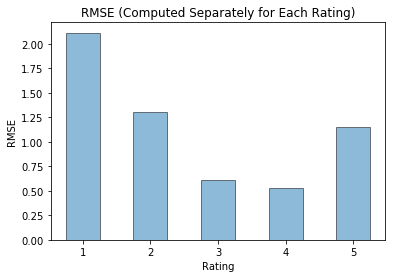

In [21]:
objects = [i for i in range(1,6)]
y_pos = np.arange(len(objects))
rmse_performance = [RMSE_r1, RMSE_r2, RMSE_r3, RMSE_r4, RMSE_r5]
 
plt.bar(y_pos, rmse_performance, width=0.5, align='center', alpha=0.5, edgecolor = "black")
# (left, height, width=0.8, bottom=None, hold=None, data=None, **kwargs)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.xlabel('Rating')
plt.title('RMSE (Computed Separately for Each Rating)')
 
plt.show()

### Let us now plot the RMSE per user. We will bin the users in 5 different categories based on their average rating (which we can get from the training data). For example, if the average ratings for each user range from the lowest average of 3 to the highest average of 4.9, then we will create 5 intervals between 3 and 4.9, and then for every one of those 5 bins we will plot the RMSE for all the users in that bin.

In [22]:
'''Compute the average rating that each user gives across all movies that s/he has rated'''
avg_rating_by_user = []

# Note to self: as a reminder on understanding what's going on in the below for loop, recall the following 2 lines of code
# have identical results:
#
# [element for element in A_uabase[i] if element > 0]
# A_uabase[i][A_uabase[i, :] > 0]
#
# In both cases, it prints out only the column elements in the row A_uabase[i] where the elements have value > 0.
# So we can use this to get a list of only those movies that a specific user i has rated, and then
# take the mean thereof, thereby computing the avg. rating that user i gives across all movies s/he has rated.
for u in range(total_users):
    avg_rating_by_user.append(np.mean(A_uabase[u][A_uabase[u, :] > 0]))

# # Alternate method to compute the above, for sanity check (comment out once done checking)
# avg_rating_by_user_alt = []
# for u in range(total_users):
#     all_ratings_by_user_u = [element for element in A_uabase[u] if element > 0]
#     mean_rating = np.mean(all_ratings_by_user_u)
#     avg_rating_by_user_alt.append(mean_rating)
# print("Double-check: Avg. rating by the last 10 users (from ua.base):\n{}".format(avg_rating_by_user_alt[-10:]))

# # Making sure that the two methods above yield the same result (comment out once done checking)
# for r in range(len(avg_rating_by_user)):
#     if (avg_rating_by_user[r] != avg_rating_by_user_alt[r]):
#         raise ValueError("avg_rating_by_user and avg_rating_by_user_alt should be the same, but they're not! " +\
#                          "Something is wrong!")

# Now that we know the avg. rating by all users, let's get the min. and max avg rating, so we know the range.
sorted_avg_rating = sorted(avg_rating_by_user)
min_avg_rating, max_avg_rating = sorted_avg_rating[0], sorted_avg_rating[-1]
print("Min. and max. average rating (respectively):", min_avg_rating, max_avg_rating)

# We now create 5 intervals ("bins") covering the range between min. and max. avg rating, so that we can
# compute the RMSE for all the users in each bin.
intervals = 5
bin_interval = (max_avg_rating - min_avg_rating) / intervals
print("We will divide the above into 5 bins. The interval for the bin:", bin_interval)

# We will divide the users into 5 bin "groups", separated by the divisors as below.
divisors = []
div_location = min_avg_rating
for i in range(intervals):
    div_location += bin_interval
    divisors.append(div_location)
print("DIVISORS:", divisors)

# Compute the RMSE for each bin.
# @param R: The recommender system matrix
# @param np_test: the np array pertaining to the test data (to compare our prediction against the ground truth)
# @param avg_rating_by_user: a list, where avg_rating_by_user[u] = the avg. rating the user gave across all movies s/he rated
# @lower_bound: see upper_bound
# @upper_bound: (lower_bound, upper_bound] indicates the range of the "bin" that we will consider in computing the RMSE.
#               If avg_rating_by_user[u] falls outside this range, it means it's outside of the "bin", and
#               we do not factor this rating into our RMSE computation for the current bin.
def compute_RMSE_bins(R, np_test, avg_rating_by_user, lower_bound, upper_bound):
    summation = 0.0
    np_test_considered = 0
    users = set()
    for row in np_test:
        userID = row[0] - 1
        movieID = row[1] - 1
        rating = row[2]
        avg_rating = avg_rating_by_user[userID]
        if (avg_rating <= lower_bound or avg_rating > upper_bound):
            continue
        np_test_considered += 1
        users.add(userID)
        summation += ((R[userID][movieID] - rating) ** 2)
    RMSE = (summation / np_test_considered) ** (1/2)
    return RMSE, len(users)

# Invoke the above method to compute RMSE for each bin.
# As a sanity check, keep track of the no. of users in each bin.
# The users must add up to 943, which is the total number of users.
RMSE_bin1, users_in_bin1 = compute_RMSE_bins(R_ua, np_uatest, avg_rating_by_user, 0, divisors[0])
RMSE_bin2, users_in_bin2 = compute_RMSE_bins(R_ua, np_uatest, avg_rating_by_user, divisors[0], divisors[1])
RMSE_bin3, users_in_bin3 = compute_RMSE_bins(R_ua, np_uatest, avg_rating_by_user, divisors[1], divisors[2])
RMSE_bin4, users_in_bin4 = compute_RMSE_bins(R_ua, np_uatest, avg_rating_by_user, divisors[2], divisors[3])
RMSE_bin5, users_in_bin5 = compute_RMSE_bins(R_ua, np_uatest, avg_rating_by_user, divisors[3], divisors[4])
print("\nRMSE (for bins 1-5):", RMSE_bin1, RMSE_bin2, RMSE_bin3, RMSE_bin4, RMSE_bin5)
print("No. of users in each bin (1-5): ", users_in_bin1, users_in_bin2, users_in_bin3, users_in_bin4, users_in_bin5)
print("Total no. of users (expected 943):", np.sum([users_in_bin1,users_in_bin2,users_in_bin3,users_in_bin4,users_in_bin5]))

Min. and max. average rating (respectively): 1.48941176471 4.92857142857
We will divide the above into 5 bins. The interval for the bin: 0.687831932773
DIVISORS: [2.1772436974789917, 2.8650756302521012, 3.5529075630252107, 4.2407394957983202, 4.9285714285714297]

RMSE (for bins 1-5): 1.10886596579 1.15083430531 1.00076338174 0.926408980006 0.887866917339
No. of users in each bin (1-5):  6 45 367 464 61
Total no. of users (expected 943): 943


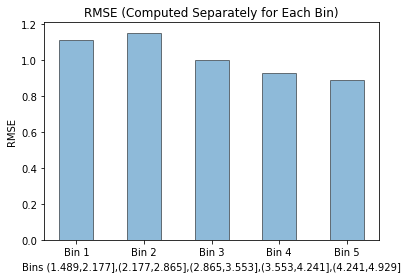

In [25]:
# objects = ['Bin 1 (1.489-2.177)', 'Bin 2(2.177-2.865)', 'Bin 3(2.865-3.553)', 'Bin 4(3.553,4.241)', 'Bin 5(4.241,4.929)']
objects = ['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5']
y_pos = np.arange(len(objects))
rmse_performance = [RMSE_bin1, RMSE_bin2,RMSE_bin3,RMSE_bin4,RMSE_bin5]
 
plt.bar(y_pos, rmse_performance, width=0.5, align='center', alpha=0.5, edgecolor = "black")
# (left, height, width=0.8, bottom=None, hold=None, data=None, **kwargs)
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.xlabel('Bins (1.489,2.177],(2.177,2.865],(2.865,3.553],(3.553,4.241],(4.241,4.929]')
plt.title('RMSE (Computed Separately for Each Bin)')
 
plt.show()

# Another Recommender System via Similarity Matrix
### Next, we will build another recommender system based on section 4.2 of the reading "Movie Rating Estimation and Recommendation" by Bao and Xia: for a (u,i) pair, compute the rating by using the item similarity function.

In [26]:
# Let's begin by building a function that computes the list of all users who rated each movie item
# @param A preprocessed matrix, e.g. A_uabase
def get_user_indices_who_rated_movie(A):
    user_indices_who_rated_movie = {}  # We will return a dictionary, with movie index as key and list of users as the value
    A_tr = A.transpose()               # For convenience we'll transpose the matrix
    for i in range(len(A_tr)):
        # This is the list of users who rated movie i, by giving the movie a rating of at least 1
        user_indices_who_rated_movie[i] = [u for u in range(len(A_tr[i])) if A_tr[i][u] > 0] 
    return user_indices_who_rated_movie

# call the above function. This returns a dictionary
users_who_rated_movie = get_user_indices_who_rated_movie(A_uabase)

# Computes total no. of movies that user u rated. Will be used as sanity check
def get_no_of_movies_that_user_rated(users_who_rated_movie, u):
    no_of_movies_that_user_rated = 0
    # Go thru every movie index and include them in the sum if user u rated it
    for i in users_who_rated_movie.keys():
        # Did user u rate movie i? If so, increment the sum
        if u in users_who_rated_movie[i]:
            no_of_movies_that_user_rated += 1
    return no_of_movies_that_user_rated

# This is just a sanity check. We'll verify correctness of the method get_user_indices_who_rated_movie()
# by using two different ways to compute the same thing: total no. of movies that user u rated (iterating thru every u)
# These two different ways should yield the same result.
for u in range(total_users):
    # m and m_prime computes the same thing and should be equal for every user u
    m = get_no_of_movies_that_user_rated(users_who_rated_movie, u)
    m_prime = len([element for element in A_uabase[u] if element > 0])
#     print ("m, m_prime:", m, m_prime)
    if (m != m_prime):
        raise ValueError ("m and m_prime should be equal, but they're not. Something is wrong!")

### We will also create a function that returns a set of users that rated both movie items i1 and i2. This function will be later used to create a similarity matrix.

In [37]:
# Computes the indices of all users that rated both movies, i1 and i2. Returns a set of such user indices.
# @param users_who_rated_movie: a dictionary with movie index as key and list of users that rated it as the value.
#        previously computed above.
# @param i1, i2: indices of movies. Assumes i1 != i2.
def get_user_indices_who_rated_both_movies(users_who_rated_movie, i1, i2):
    raters_i1 = users_who_rated_movie[i1]
    raters_i2 = users_who_rated_movie[i2]
    return set(raters_i1).intersection(raters_i2)

### Let's now make up the similarity matrix. See the comments below for the formula we use.

In [38]:
'''
# Similarity(i1, i2) = 
#
#                      sum_{u /in U(i1) /intersect U(i2)} [(R_u,i1 - R_u)(R_u,i2 - R_u)]
# --------------------------------------------------------------------------------------------------------------------
# sqrt([sum_{u /in U(i1) /intersect U(i2)} (R_u,i1 - R_u)^2] * [sum_{u /in U(i1) /intersect U(i2)} [(R_u,i2 - R_u)^2])
#
# where:
# U(i1): set of all users who have rated movie item i1
# U(i2): set of all users who have rated movie item i2
# U(i1) /intersect U(i2): set of all users who have rated both i1 and i2
# R_u,i1: the rating that user u gave to movie i1
# R_u,i2: the rating that user u gave to movie i2
# R_u: average rating by user u across all movies that s/he rated
'''
def build_similarity_matrix(A, avg_rating_by_user, user_indices_who_rated_movie):
    num_total_movies = len(A[0]) # Should be 1682 total movies
    S = np.zeros((num_total_movies, num_total_movies)) # Initialize a 1682 x 1682 similarity matrix
    epsilon = 1e-5  # Used in the event that numerator is 0
    for i1 in range(num_total_movies):
        for i2 in range(i1, num_total_movies):
            # Similarity rating range is [-1, 1]. If two movie indices are identical, then set similarity to 1.
            if (i1 == i2):
                S[i1][i2] = 1
                continue
                
            # If indices aren't identical, apply the formula above.
            ####################################
            ### Begin by computing numerator ###
            ####################################
            set_users_who_rated_both = get_user_indices_who_rated_both_movies(users_who_rated_movie, i1, i2)
            numerator = 0.0
            for u in set_users_who_rated_both:
                R_u = avg_rating_by_user[u]
                numerator += (A[u][i1] - R_u)*(A[u][i2] - R_u)
            # Alt. way to compute numerator just for sanity check
            numerator_alt = np.sum([(A[u][i1] - avg_rating_by_user[u])*(A[u][i2] - avg_rating_by_user[u])\
                            for u in set_users_who_rated_both])
            # Make sure both ways of computing numerator lead to same result
            if(abs(numerator - numerator_alt) > epsilon): 
                raise ValueError("numerator and numerator_alt should be equal, but they're not! Something's wrong!")
            
            # Also compute numerator value with epsilon, just as backup in case we get 0 numerator
            numerator_w_epsilon = np.sum([(A[u][i1] - avg_rating_by_user[u] + epsilon)*\
                                          (A[u][i2] - avg_rating_by_user[u] + epsilon) \
                                          for u in set_users_who_rated_both])
            
            ###########################
            ### Compute denominator ###
            ###########################
            sum_1stterm = 0
            sum_2ndterm = 0
            for u in set_users_who_rated_both:
                sum_1stterm += ((A[u][i1] - avg_rating_by_user[u]) ** 2)
                sum_2ndterm += ((A[u][i2] - avg_rating_by_user[u]) ** 2)
            denominator = np.sqrt(sum_1stterm * sum_2ndterm)
            
            # Sanity check: Make sure both ways of computing denominator lead to same result
            denominator_alt = np.sqrt(
                        np.sum([(A[u][i1] - avg_rating_by_user[u]) ** 2 for u in set_users_who_rated_both])*\
                        np.sum([(A[u][i2] - avg_rating_by_user[u]) ** 2 for u in set_users_who_rated_both])
                        )
            if abs(denominator - denominator_alt) > epsilon:
                raise ValueError("denom and denom_alt should be equal, but they're not! Something's wrong!")
            
            # Also compute denom with epsilon, just as backup in case we get 0 denominator
            denominator_w_epsilon = np.sqrt(
                        np.sum([(A[u][i1] - avg_rating_by_user[u] + epsilon) ** 2 for u in set_users_who_rated_both])*\
                        np.sum([(A[u][i2] - avg_rating_by_user[u] + epsilon) ** 2 for u in set_users_who_rated_both])
                        )
            
            # Check for 0 numerator and/or denominator.
            # If denom is 0, then just set similarity to 0.
            # Else, if numerator is 0, use the num and denom values computed with epsilon
            # Else (neither numer nor denom is zero), just divide.
            if denominator == 0:
                S[i1][i2] = 0
                S[i2][i1] = S[i1][i2]
            elif numerator == 0:
                S[i1][i2] = numerator_w_epsilon / denominator_w_epsilon
                S[i2][i1] = S[i1][i2]
            else:
                S[i1][i2] = numerator / denominator
                S[i2][i1] = S[i1][i2]
    return S
# end build_similarity_matrix

# Build similarity matrix by invoking above method
S = build_similarity_matrix(A_uabase, avg_rating_by_user, users_who_rated_movie)
print(S)

# Check to see all elements are in the valid similarity range of [-1, 1] (while accounting for small floating value errors)
epsilon = 0.00001
for row in S:
    invalid_values = [element for element in row if element < (-1. - epsilon) or element > (1. + epsilon)]
    if len(invalid_values) > 0:
        print(invalid_values)
        raise ValueError("ERROR: The similarity matrix contains elements that are outside of the range [-1, 1].")

[[ 1.         -0.10845401 -0.13649914 ...,  0.          1.         -1.        ]
 [-0.10845401  1.          0.08719047 ...,  0.          1.          1.        ]
 [-0.13649914  0.08719047  1.         ...,  0.          0.          1.        ]
 ..., 
 [ 0.          0.          0.         ...,  1.          0.          0.        ]
 [ 1.          1.          0.         ...,  0.          1.          0.        ]
 [-1.          1.          1.         ...,  0.          0.          1.        ]]


### Printing some sections of the similarity matrix just for testing.

In [39]:
print(S[0][:10])
print(S[10][10:20])
print(S[-1][-10:])

[ 1.         -0.10845401 -0.13649914 -0.09945136  0.04588     0.2214648
  0.15793617  0.28992768  0.10362926  0.01014528]
[ 1.          0.35048723 -0.18690751 -0.00651632  0.20387371 -0.15861479
  0.08342795 -0.02089445  0.22690778 -0.34249381]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


### Now that we have built the similarity matrix, we will use weighted sum formula (see comments below) to predict the movie rating for each (u, i) pair.

In [54]:
'''
Predicted_Rating(u, i) = 

sum_{n, where n /in the set of (k movies that are most similar to i that user u has rated)} (S(i, n) * R(u, n))
---------------------------------------------------------------------------------------------------------------
     sum_{n, where n /in the set of (k movies that are most similar to i that user u has rated)} |S(i,n)|
     
where:
S(i, n) = the similarity rating between movie index i and movie index n
R(u, n) = the rating that user u gave to movie n
|S(i, n)| = absolute value of the similarity rating between i and n

NOTE: if user u has rated fewer than k movies, then we just use all the movies that s/he has rated.
'''

'''
So, basic prediction steps are as follows:
1.) Get the similarity matrix (this is already done above)
2.) Loop over all NONZERO entries (u,i) in the TESTING data, e.g. A_uatest. We do this for efficiency reasons; we're
    only going to make predictions for those ratings that are included in the test data
    (without actually peeking at the answers in the testing data -- that'd be cheating), so we can
    compare our predictions for only those entries with the ground truth in the testing data and compute the RMSE.
    For the rest of this instruction, let's say that we're looking at movie item i.
    2.1) find the list of items that the user has rated as given by the TRAINIG data (say that this list is L = [y,z,w]).
    2.2) look at the similarity for (i,y), (i,z), (i,w) in the similarity matrix.
    2.3) sort the similarity and choose the k highest values (if k > len(L), then just choose all values in list)
    2.4) do the weighted sum as given above (see the above formula) and add this value to the recommender matrix R[u][i]
'''
        
'''
Build recommender system
As stated above, to save time we'll only predict those entries where
the testing data has a nonzero entry at (u, i).
'''
def buildRecommender_KNN(S, A, Atest, k, global_average_rating):
    total_num_users = len(A)
    total_num_movies = len(A[0])
    R = np.zeros((total_num_users, total_num_movies))
    
    # Begin loop to build recommender matrix
    for u in range(total_num_users):
        for i in range(total_num_movies):
            
            # Don't bother predicting rating where testing data doesn't have the ground truth
            if Atest[u][i] == 0:
#                 print("Test data doesn't include entry for ({},{}). Continuing...".format(u,i))
                continue  
                
            # Get a list of all movie indices that user u has rated (as seen in training data)
            all_movies_u_rated = [j for j in range(len(A[u])) if A[u][j] > 0]
            
            # Now look at the similarity rating between movie i and all the movies in the above list
            # We'll keep a tuple of (similarity rating, movie_index) for each movie_index as compared to movie i.
            similarity = [(S[i][movie_index], movie_index) for movie_index in all_movies_u_rated]
            
            # get the list of k most similar items to movie i
            k_most_similar = sorted(similarity, reverse=True)[:k]
#             print("k_most_similar for (u, i) = ({}, {}): {}".format(u, i, k_most_similar))
                        
            numerator = np.sum([S[i][n] * A[u][n] for (similarity_rating, n) in k_most_similar])
            denominator = np.sum([abs(S[i][n]) for (similarity_rating, n) in k_most_similar])
            
            if (denominator) == 0:
                R[u][i] = global_average_rating
            else:
                R[u][i] = numerator / denominator
                if(np.isnan(R[u][i])):
                    R[u][i] = global_average_rating
    return R

### Let us try K-values of 1, 2, 3, 5, and 10.

In [55]:
R_knn1 = buildRecommender_KNN(S, A_uabase, A_uatest, 1, mu_uabase)
R_knn2 = buildRecommender_KNN(S, A_uabase, A_uatest, 2, mu_uabase)
R_knn3 = buildRecommender_KNN(S, A_uabase, A_uatest, 3, mu_uabase)
R_knn5 = buildRecommender_KNN(S, A_uabase, A_uatest, 5, mu_uabase)
R_knn10 = buildRecommender_KNN(S, A_uabase, A_uatest, 10, mu_uabase)

### Calculate the overall RMSE for each value of K, plot them and find the optimal one.

RMSE for K = 1,2,3,5,10 (respectively): 1.37283711269 1.18735791402 1.12077081995 1.07611582867 1.32875048579


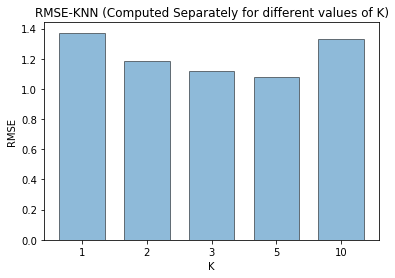

In [56]:
RMSE_knn1 = compute_overall_RMSE(R_knn1, np_uatest)
RMSE_knn2 = compute_overall_RMSE(R_knn2, np_uatest)
RMSE_knn3 = compute_overall_RMSE(R_knn3, np_uatest)
RMSE_knn5 = compute_overall_RMSE(R_knn5, np_uatest)
RMSE_knn10 = compute_overall_RMSE(R_knn10, np_uatest)
print("RMSE for K = 1,2,3,5,10 (respectively):", RMSE_knn1, RMSE_knn2, RMSE_knn3, RMSE_knn5, RMSE_knn10)

objects = [1, 2, 3, 5, 10]
y_pos = np.arange(len(objects))
rmse_performance = [RMSE_knn1, RMSE_knn2,RMSE_knn3,RMSE_knn5,RMSE_knn10]
 
plt.bar(y_pos, rmse_performance, width=0.7, align='center', alpha=0.5, edgecolor = "black")
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.xlabel('K')
plt.title('RMSE-KNN (Computed Separately for different values of K)')
 
plt.show()

### We can see above that K = 5 yields the smallest RMSE.

### Let's dig a bit deeper by look at k=2 and k=5, and plotting the RMSE per user x movie rating. For example plot the RMSE for all the test user x movies that have training rating 1,2,3,4,5.
### Below is the bar graph for K = 2.

2.04712148084 1.4344402675 0.934738549104 0.943522506031 1.34691732001


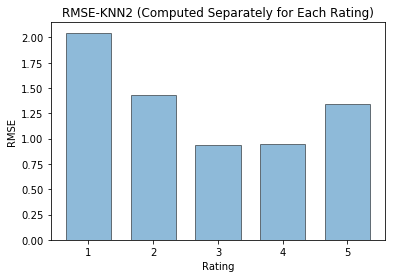

In [57]:
RMSE_knn2_r1 = compute_RMSE_partial(R_knn2, np_uatest, 1)
RMSE_knn2_r2 = compute_RMSE_partial(R_knn2, np_uatest, 2)
RMSE_knn2_r3 = compute_RMSE_partial(R_knn2, np_uatest, 3)
RMSE_knn2_r4 = compute_RMSE_partial(R_knn2, np_uatest, 4)
RMSE_knn2_r5 = compute_RMSE_partial(R_knn2, np_uatest, 5)
print(RMSE_knn2_r1,RMSE_knn2_r2,RMSE_knn2_r3,RMSE_knn2_r4,RMSE_knn2_r5)

objects = [1, 2, 3, 4, 5]
y_pos = np.arange(len(objects))
rmse_performance = [RMSE_knn2_r1, RMSE_knn2_r2,RMSE_knn2_r3,RMSE_knn2_r4,RMSE_knn2_r5]
 
plt.bar(y_pos, rmse_performance, width=0.7, align='center', alpha=0.5, edgecolor="black")
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.xlabel('Rating')
plt.title('RMSE-KNN2 (Computed Separately for Each Rating)')
 
plt.show()

### And here is the graph for K = 5.

2.01852424776 1.34580982722 0.824942188209 0.770181172444 1.23674547401


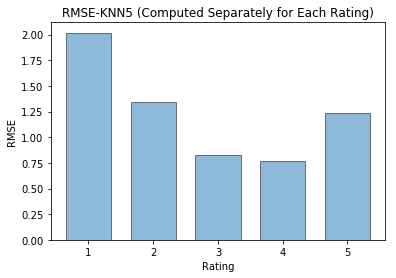

In [58]:
RMSE_knn5_r1 = compute_RMSE_partial(R_knn5, np_uatest, 1)
RMSE_knn5_r2 = compute_RMSE_partial(R_knn5, np_uatest, 2)
RMSE_knn5_r3 = compute_RMSE_partial(R_knn5, np_uatest, 3)
RMSE_knn5_r4 = compute_RMSE_partial(R_knn5, np_uatest, 4)
RMSE_knn5_r5 = compute_RMSE_partial(R_knn5, np_uatest, 5)
print(RMSE_knn5_r1,RMSE_knn5_r2,RMSE_knn5_r3,RMSE_knn5_r4,RMSE_knn5_r5)

objects = [1, 2, 3, 4, 5]
y_pos = np.arange(len(objects))
rmse_performance = [RMSE_knn5_r1, RMSE_knn5_r2,RMSE_knn5_r3,RMSE_knn5_r4,RMSE_knn5_r5]
 
plt.bar(y_pos, rmse_performance, width=0.7, align='center', alpha=0.5, edgecolor = "black")
plt.xticks(y_pos, objects)
plt.ylabel('RMSE')
plt.xlabel('Rating')
plt.title('RMSE-KNN5 (Computed Separately for Each Rating)')
 
plt.show()

### As we did previously, we will plot the RMSE per user. by creating 5 different bins. We'll do this 5 times, for KNN-1, KNN-2, KNN-3, KNN-5 and KNN-10.

RMSE (KNN-1): [1.433932251369991, 1.5811388300841898, 1.4467081007961913, 1.3226312593749863, 1.0909463480970225]


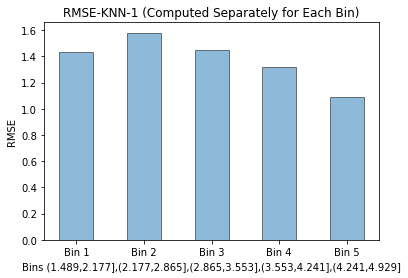

RMSE (KNN-2): [1.3631782132156653, 1.4283901451573318, 1.2514511930073196, 1.1300286251347531, 0.98525877271763496]


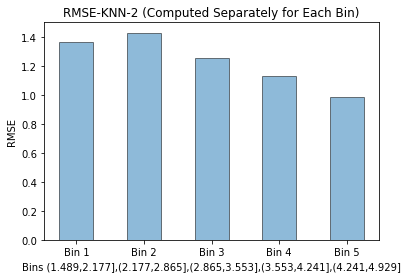

RMSE (KNN-3): [1.3269054802803881, 1.3412510649176959, 1.1728081424592429, 1.0736668675693548, 0.93501379456242595]


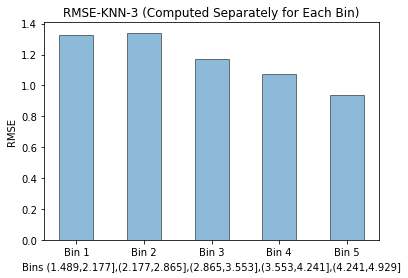

RMSE (KNN-5): [1.3433403576663707, 1.3267267673353584, 1.1095171995867921, 1.0348608287878307, 0.93457374606423149]


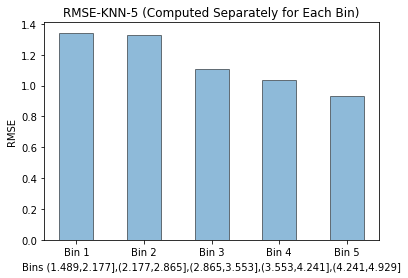

RMSE (KNN-10): [1.5228859640302226, 1.8659020003707305, 1.30990868543487, 1.2272886304696762, 1.648338545484463]


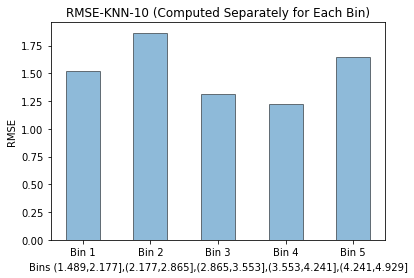

In [59]:
def plot_bins(objects, rmse_performance, title):
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, rmse_performance, width=0.5, align='center', alpha=0.5, edgecolor = "black")
    plt.xticks(y_pos, objects)
    plt.ylabel('RMSE')
    plt.xlabel('Bins (1.489,2.177],(2.177,2.865],(2.865,3.553],(3.553,4.241],(4.241,4.929]')
    plt.title(title)
    plt.show()

    
R_knn_list = [(R_knn1, 'KNN-1'), (R_knn2, 'KNN-2'), (R_knn3, 'KNN-3'), (R_knn5, 'KNN-5'), (R_knn10, 'KNN-10')]
for Rknn in R_knn_list:
    r1, u1 = compute_RMSE_bins(Rknn[0], np_uatest, avg_rating_by_user, 0, divisors[0])
    r2, u2 = compute_RMSE_bins(Rknn[0], np_uatest, avg_rating_by_user, divisors[0], divisors[1])
    r3, u3 = compute_RMSE_bins(Rknn[0], np_uatest, avg_rating_by_user, divisors[1], divisors[2])
    r4, u4 = compute_RMSE_bins(Rknn[0], np_uatest, avg_rating_by_user, divisors[2], divisors[3])
    r5, u5 = compute_RMSE_bins(Rknn[0], np_uatest, avg_rating_by_user, divisors[3], divisors[4])
    rmse_performance = [r1, r2, r3, r4, r5]
    users_in_each_bin = [u1, u2, u3, u4, u5]
    if np.sum(users_in_each_bin) != total_users:
        raise ValueError("ERROR: The users in each of the bins must sum to equal the total number of users!")
    print("RMSE ({}): {}".format(Rknn[1], rmse_performance))
    objects = ['Bin 1', 'Bin 2', 'Bin 3', 'Bin 4', 'Bin 5']
    plot_bins(objects,rmse_performance, "RMSE-{} (Computed Separately for Each Bin)".format(Rknn[1]))

### Overall, we can verify that these RMSE results outperform those of a random guess as expected.